# Digit Recognition with MNIST Dataset using PyTorch

In [1]:
# Importing Pytorch and Necessary Modules.

%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading Dataset.

train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

In [3]:
train_data = train.train_data
print(type(train_data))
train_data = train.transform(train_data.numpy())
print(type(train_data))

print(train_data.shape)

<class 'torch.ByteTensor'>
<class 'torch.FloatTensor'>
torch.Size([28, 60000, 28])


In [4]:
# Metrics.

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print(' -> Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' -> Tensor Shape:', train.train_data.size())
print(' -> Transformed Shape:', train_data.size())

 -> Numpy Shape: (60000, 28, 28)
 -> Tensor Shape: torch.Size([60000, 28, 28])
 -> Transformed Shape: torch.Size([28, 60000, 28])


In [5]:
# Designing Neural Network (Linear with Backpropogation)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # Linear Layer
        
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, 10)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        
        # Calling Initial Layers 
        h = self.fc1(x)
        h = self.bc1(h)
        
        # Defining Activation Function
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        # Calling Second Layers 
        
        h = self.fc2(h)
        h = self.bc2(h)
        
        # Second Layer Activation Function
        
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h, dim = 1)
        return out

# Creating a model.
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Model Architecture
print(model)

# Adam Optimizer
print(optimizer)

Model(
  (fc1): Linear(in_features=784, out_features=548, bias=True)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=548, out_features=252, bias=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear(in_features=252, out_features=10, bias=True)
)


In [7]:
model.train()

Model(
  (fc1): Linear(in_features=784, out_features=548, bias=True)
  (bc1): BatchNorm1d(548, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=548, out_features=252, bias=True)
  (bc2): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear(in_features=252, out_features=10, bias=True)
)

In [8]:
dataloader_args = dict(shuffle=True, batch_size=64,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [9]:
# Training model.

losses = []
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data[0])
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data[0]), 
                end='')
            
    print()

 Train Epoch: 0 [57664/60000 (96%)]	Loss: 0.108098
 Train Epoch: 1 [57664/60000 (96%)]	Loss: 0.171772
 Train Epoch: 2 [57664/60000 (96%)]	Loss: 0.105249
 Train Epoch: 3 [57664/60000 (96%)]	Loss: 0.118287
 Train Epoch: 4 [57664/60000 (96%)]	Loss: 0.060325
 Train Epoch: 5 [57664/60000 (96%)]	Loss: 0.140658
 Train Epoch: 6 [57664/60000 (96%)]	Loss: 0.119532
 Train Epoch: 7 [57664/60000 (96%)]	Loss: 0.056989
 Train Epoch: 8 [57664/60000 (96%)]	Loss: 0.083594
 Train Epoch: 9 [57664/60000 (96%)]	Loss: 0.039504
 Train Epoch: 10 [57664/60000 (96%)]	Loss: 0.033887
 Train Epoch: 11 [57664/60000 (96%)]	Loss: 0.033912
 Train Epoch: 12 [57664/60000 (96%)]	Loss: 0.025685
 Train Epoch: 13 [57664/60000 (96%)]	Loss: 0.011947
 Train Epoch: 14 [57664/60000 (96%)]	Loss: 0.012942


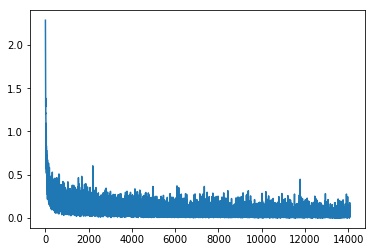

In [10]:
plot(losses)

In [11]:
# Accuracy and Evalution of trained model.

evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

Accuracy: 0.9741


In [12]:
# Outputs in Numbers for testdataset.

print(pred)


 7
 2
 1
⋮ 
 4
 5
 6
[torch.LongTensor of size 10000]



torch.Size([10000, 28, 28])
<class 'torch.autograd.variable.Variable'>
<class 'numpy.ndarray'>


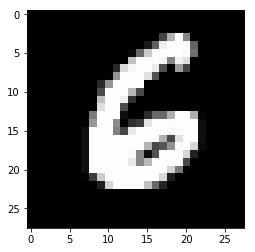

In [13]:
# Coverting Pixel Array to Image

print(evaluate_x.shape)
img = evaluate_x[131]
print(type(img))
img = img.data.cpu().numpy()
print(type(img))
plt.imshow((img).reshape(28,28), cmap=cm.gray)